In [185]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Introduction
"San Francisco International Airport reports on Monthly Passenger Traffic Statistics by Airline. On January 27, 2017, President Trump issued an executive order entitled 'Protecting the Nation from Foreign Terrorist Entry into the United States,' which suspended travel from Iran, Iraq, Libya, Somalia, Sudan and Yemen for 90 days, blocked refugees for 120 days, and suspended travel from Syria indefinitely. The goal of this exercise is to measure the impact of this executive order. Show your work starting from the exploratory analysis to the diagnosis on the model. You can return the script or notebook as an attachment and you have 1 hour to finish this exercise"

In [186]:
main_df = pd.read_csv("data/Air_Traffic_Passenger_Statistics.csv")
df = main_df
df['Activity Period'] = pd.to_datetime(
    df['Activity Period'], format='%Y%m', errors='ignore')

'''
print(main_df['Price Category Code'].unique())
print(main_df['GEO Region'].unique())
print(main_df['Activity Type Code'].unique())

print('\n<Original column data types>')
print(main_df.dtypes) # date is already in object type.
print('\n<Transformed column data types>')
print(df.dtypes)
'''

"\nprint(main_df['Price Category Code'].unique())\nprint(main_df['GEO Region'].unique())\nprint(main_df['Activity Type Code'].unique())\n\nprint('\n<Original column data types>')\nprint(main_df.dtypes) # date is already in object type.\nprint('\n<Transformed column data types>')\nprint(df.dtypes)\n"

## Hypothesis 1) Travelers from Middle East would have dropped
I want to look at year-to-year Middle Eastern travelers (in proportions) change by months. Because the executive order took place in January, let's look at Feb / Mar / April time frames across years.

Once I identify those changes (y_yr), I can perform a t-test to see if y_2018 = r_2018 - r_2017 is significantly different from others. I can use t-test because I have (sorta) isolated the time effect (e.g., seasonality) in my data by comparing by months (observations are independent to each other).

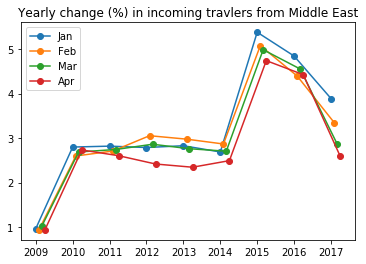

In [187]:
# I can filter GEO Summary=International, Activity Type Code=Deplaned | Thru / Transit
df_filtered = df[(df['GEO Summary']=='International')
                 & (df['Activity Type Code'].isin(['Deplaned', 'Thru / Transit']))
                ]

# Groupby and compute incoming travelers proportions
date_region = df_filtered.groupby(['Activity Period', 'GEO Region'])['Passenger Count'].sum()
date = df_filtered.groupby(['Activity Period'])['Passenger Count'].sum()
date_region_prop = date_region.div(date, level='Activity Period') * 100

# Filter out GEO Region == 'Middle East'
df_prop = pd.DataFrame({'Proportion' : date_region_prop}).reset_index()
df_prop = df_prop[df_prop['GEO Region'] == 'Middle East']

ax = plt.figure()
plt.title('Yearly change (%) in incoming travlers from Middle East')

# Compute y_yr
y_train = list()
y_test = list()
for m in range(1, 13):
    df_m = df_prop[df_prop['Activity Period']
    .map(lambda x: pd.to_datetime(x, format='%Y%m').month) == m]
    y_train += list(df_m['Proportion'][1:-1] - df_m['Proportion'][:-2].values)
    y_test.append(list(df_m['Proportion'])[-1] - list(df_m['Proportion'])[-2])
    
    # plot yearly change for Feb
    months = ['Jan', 'Feb', 'Mar', 'Apr']
    if m in [1, 2, 3, 4]:
        plt.plot(df_m['Activity Period'], df_m['Proportion'], label=months[m-1], marker='o')
   
plt.legend()

In [188]:
# two-sample t-test, assuming equal variance
# I assume that the two samples (train and test) are independently sampled, so are all y_yrs
# Two samples (populations) are normally distributed.
from scipy import stats
result = stats.ttest_ind(y_train, y_test) # n1 != n2, variance assumptinon will make difference

print('t-stat: %s, p-val: %s'%(result[0], result[1]))

t-stat: 5.22365472489, p-val: 1.14343521355e-06
